## 1) Let's make sure we have all our imports.

In [2]:
import numpy as np
import torch
from itertools import product
from typing import Sequence, Tuple, Optional
import time
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
import json


In [3]:
!pip install rdkit

!pip install tqdm

!pip install scikit-learn

## 2) Utility Functions

In [4]:
################################################################################
# Utility functions
################################################################################

def compute_translation(center: np.ndarray,
                        grid_size: int = 48,
                        voxel_size: float = 1.0) -> np.ndarray:
    """Return the translation vector that places *center* at the grid centre."""
    grid_center = ((grid_size - 1) / 2.0) * voxel_size
    return grid_center - center


def gaussian_kernel(radius: int = 2, sigma: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """Return neighbour offsets and weights for a 3‑D isotropic Gaussian.

    Parameters
    ----------
    radius
        Number of voxels in each direction to include.
    sigma
        Standard deviation (in voxels).

    Returns
    -------
    offsets : (K, 3) int array
        Relative integer offsets.
    weights : (K,) float array
        Corresponding weights ∈ [0, 1].
    """
    offsets = np.array(list(product(range(-radius, radius + 1),
                                    repeat=3)), dtype=np.int8)
    # exclude origin – it is handled separately
    offsets = offsets[(offsets != 0).any(axis=1)]
    distances2 = (offsets ** 2).sum(axis=1).astype(np.float32)
    weights = np.exp(-distances2 / (2 * sigma ** 2))
    return offsets, weights



In [5]:
################################################################################
# Core voxelisation
################################################################################

def voxelise_atoms(atom_coords: np.ndarray,
                   atom_feats: np.ndarray,
                   *,
                   grid_size: int = 48,
                   voxel_size: float = 1.0,
                   centre: Optional[np.ndarray] = None,
                   gaussian_radius: int = 2,
                   gaussian_sigma: float = 1.0
                   ) -> np.ndarray:
    """Convert atomic coordinates + features to a (C, N, N, N) voxel grid.

    Parameters
    ----------
    atom_coords : (N_atoms, 3) float32 array
        Cartesian XYZ coordinates in ångströms.
    atom_feats : (N_atoms, C) float32 array
        Per‑atom feature vectors (same channels *C* for every atom).
    centre
        If *None*, the coordinates’ centroid is used. Otherwise, supply a
        (3,) array – for example, the ligand centroid – that will be mapped
        to the geometric centre of the grid.
    gaussian_radius
        Radius, in voxels, of the isotropic Gaussian used to smooth/distribute
        the signal. Use 0 to disable smoothing.
    gaussian_sigma
        Standard deviation (in voxels) of the Gaussian.

    Returns
    -------
    grid : (C, grid_size, grid_size, grid_size) float32 array
    """
    assert atom_coords.shape[0] == atom_feats.shape[0], "Mismatched atoms/feats"
    C = atom_feats.shape[1]
    grid = np.zeros((C, grid_size, grid_size, grid_size), dtype=np.float32)

    if centre is None:
        centre = atom_coords.mean(axis=0, dtype=np.float32)

    # translate so that *centre* maps to the grid midpoint
    translation = compute_translation(centre, grid_size, voxel_size)
    shifted = atom_coords + translation[None, :]

    # integer voxel indices
    indices = np.floor(shifted / voxel_size).astype(np.int16)  # (N,3)

    # mask atoms that fall outside the grid
    valid = ((indices >= 0) & (indices < grid_size)).all(axis=1)
    indices, feats = indices[valid], atom_feats[valid]

    # pre‑build Gaussian neighbours
    if gaussian_radius > 0:
        neigh_offsets, neigh_weights = gaussian_kernel(gaussian_radius, gaussian_sigma)

    for (x, y, z), f in zip(indices, feats):
        # contribute to the central voxel
        grid[:, x, y, z] += f

        # optionally spread to neighbours
        if gaussian_radius > 0:
            neigh_idx = np.stack([x, y, z]) + neigh_offsets  # (K,3)
            # keep neighbours inside the grid boundaries
            valid_neigh = ((neigh_idx >= 0) & (neigh_idx < grid_size)).all(axis=1)
            neigh_idx = neigh_idx[valid_neigh]
            neigh_w   = neigh_weights[valid_neigh]

            for (nx, ny, nz), w in zip(neigh_idx, neigh_w):
                grid[:, nx, ny, nz] += f * w

    return grid


In [6]:
################################################################################
# Example torch Dataset
################################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F # Import F for functional API like F.mse_loss
from torch.utils.data import DataLoader # Ensure DataLoader is imported here if not already

class VoxelDataset(torch.utils.data.Dataset):
    """Minimal dataset for protein–ligand voxel grids."""

    def __init__(self,
                 complexes: Sequence[Tuple[str, str]], # Add type hints for clarity
                 label_func,
                 cutoff: float = 6.0,
                 grid_size: int = 48,
                 voxel_size: float = 1.0,
                 channels: int = 19 # Set default to 19 as per example
                 ):
        """Parameters
        ----------
        complexes
            Iterable of protein–ligand complexes as tuples of (protein_mol2_path, ligand_mol2_path).
        label_func
            Callable that returns a scalar target given the protein and ligand paths.
        cutoff
            Distance (Å) around the ligand to include protein atoms.
        grid_size : int
            Size of the voxel grid along each dimension.
        voxel_size : float
            Resolution of each voxel in Å.
        channels : int
            Number of feature channels per atom.
        """
        self.complexes   = list(complexes)
        self.label_func  = label_func
        self.cutoff      = cutoff
        self.grid_size   = grid_size
        self.voxel_size  = voxel_size
        self.channels    = channels # Keep channels parameter but use 19 in example

    def _extract_atoms_from_mols(self, protein_mol, protein_conf, ligand_mol, ligand_conf):
        """Return coords and features of atoms within *cutoff* of the ligand."""
        coords, feats = [], []

        # ligand atoms
        # Safely attempt to get ligand atom positions
        try:
            lig_coords = np.array([ligand_conf.GetAtomPosition(i) for i in range(ligand_mol.GetNumAtoms())], dtype=np.float32)
        except Exception as e:
             # Catch potential errors during position retrieval
             print(f"Error extracting ligand positions: {e}. Returning empty arrays.")
             return np.empty((0, 3), dtype=np.float32), np.empty((0, self.channels), dtype=np.float32)


        # Check if lig_coords is empty after creation
        if lig_coords.shape[0] == 0:
            # No ligand atoms found or extracted successfully.
            # Return empty arrays for coords and feats.
            print("No ligand atom coordinates extracted. Returning empty arrays.")
            return np.empty((0, 3), dtype=np.float32), np.empty((0, self.channels), dtype=np.float32)


        # If ligand atoms were extracted, process them
        for i, at in enumerate(ligand_mol.GetAtoms()):
            # Check if the atom index is valid within lig_coords (should be if lig_coords has shape > 0)
            if i < lig_coords.shape[0]:
                 pos = lig_coords[i] # Use the numpy array we already created
                 coords.append(pos)
                 # Pass the atom and molecule type (+1 for ligand)
                 feats.append(atom_to_feature_vec(at, +1))
            else:
                 print(f"Warning: Ligand atom index {i} out of bounds for extracted positions ({lig_coords.shape[0]}). Skipping atom.")


        # protein atoms within *cutoff* Å of any ligand atom
        # Ensure lig_coords_np is used for distance calculation only if it's not empty
        if lig_coords.shape[0] > 0:
             # Ensure lig_coords is a numpy array of float32 (already done above)
             lig_coords_np = lig_coords

             for i, at in enumerate(protein_mol.GetAtoms()):
                 # Safely attempt to get protein atom position
                 try:
                     pos = protein_conf.GetAtomPosition(i)
                     p   = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                 except Exception as e:
                     print(f"Error extracting protein position for atom {i}: {e}. Skipping atom.")
                     continue # Skip this protein atom


                 # Check distance to any ligand atom ONLY if lig_coords is not empty
                 if np.min(np.linalg.norm(lig_coords_np - p, axis=1)) > self.cutoff:
                     continue
                 coords.append(p)
                 # Pass the atom and molecule type (-1 for protein)
                 feats.append(atom_to_feature_vec(at, -1))
        else:
            print("Ligand coordinates are empty, skipping protein atom distance check.")
            # If ligand coords are empty, no protein atoms within cutoff can exist.
            # The coords and feats lists will only contain ligand atoms (which is zero in this branch).


        return np.asarray(coords, np.float32), np.asarray(feats, np.float32)


    def __len__(self):
        return len(self.complexes)

    def __getitem__(self, idx):
        # comp is a tuple: (protein_mol2_path, ligand_mol2_path)
        prot_path, lig_path = self.complexes[idx]
        print(f"Processing complex: {os.path.basename(os.path.dirname(prot_path))}")

        # Load molecules using the previously defined load_mol2 function
        protein_mol, protein_conf = load_mol2(prot_path)
        ligand_mol, ligand_conf = load_mol2(lig_path)

        # Handle cases where loading failed or no conformer was found
        if protein_mol is None or protein_conf is None or ligand_mol is None or ligand_conf is None:
             print(f"Skipping complex due to loading/conformer error: {prot_path}, {lig_path}")
             # Depending on your needs, you might skip this item,
             # raise an error, or return None/handle it in the DataLoader.
             # For simplicity here, we'll return None and filter later if needed.
             # A more robust approach for DataLoader is to raise an error
             # or return a placeholder that downstream code can handle.
             # Let's raise an error for clarity during debugging.
             return None, None


        # Extract atoms and features from the loaded molecules
        coords, feats = self._extract_atoms_from_mols(protein_mol, protein_conf, ligand_mol, ligand_conf)

        # Check if _extract_atoms_from_mols returned empty arrays
        if coords.shape[0] == 0:
             print(f"Skipping complex due to no atoms extracted: {prot_path}, {lig_path}")
             return None, None

        # Calculate centre on ligand centroid for robustness
        # Use the loaded ligand conformer's atom positions
        ligand_atom_coords = np.array([ligand_conf.GetAtomPosition(i) for i in range(ligand_mol.GetNumAtoms())], dtype=np.float32)
        centre = np.mean(ligand_atom_coords, axis=0, dtype=np.float32)


        # Voxelise atoms
        grid = voxelise_atoms(coords, feats,
                              grid_size=self.grid_size,
                              voxel_size=self.voxel_size,
                              centre=centre)

        # convert to torch tensors
        grid  = torch.from_numpy(grid)
        # Call label_func with the paths, as defined in your example
        label = torch.tensor(self.label_func(prot_path, lig_path), dtype=torch.float32)

        # print("Shape of the grid:", grid.shape)

        return grid, label

In [7]:
# ----------------------------------------------------------
# 1.  Imports & constants
# ----------------------------------------------------------
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# 19-channel layout ------------------------------------------------------------
#  0-8 : one-hot element   (B, C, N, O, P, S, Se, halogen, metal)
#    9 : hybridisation     (1, 2, 3  → sp, sp2, sp3; 0 = “other”)
#   10 : heavy-atom bonds  (# neighbours with Z > 1)
#   11 : hetero-atom bonds (# neighbours with Z not in {1, 6})
# 12-16: one-hot structural (hydrophobic, aromatic, acceptor, donor, ring)
#   17 : partial charge    (Gasteiger)
#   18 : molecule type     (–1 protein, +1 ligand)
# ------------------------------------------------------------------------------
FEATURE_DIM = 19
ELEMENTS     = {5:0, 6:1, 7:2, 8:3, 15:4, 16:5, 34:6}       # explicit slots
HALOGENS     = {9, 17, 35, 53}
# every other Z > 1 that isn’t in ELEMENTS ∪ HALOGENS is considered “metal”

# ----------------------------------------------------------
# 2.  Atom-level feature builder
# ----------------------------------------------------------
def atom_to_feature_vec(atom, mol_type: int) -> np.ndarray:
    """Return a (19,) float32 feature vector for one RDKit atom."""
    vec = np.zeros(FEATURE_DIM, dtype=np.float32)

    # 1) element (9 one-hot channels)
    Z   = atom.GetAtomicNum()
    idx = ELEMENTS.get(Z, 7 if Z in HALOGENS else 8)
    vec[idx] = 1.0                           # channels 0-8

    # 2) hybridisation
    hyb = {Chem.rdchem.HybridizationType.SP: 1,
           Chem.rdchem.HybridizationType.SP2: 2,
           Chem.rdchem.HybridizationType.SP3: 3}.get(atom.GetHybridization(), 0)
    vec[9] = float(hyb)

    # 3) heavy-atom & hetero-atom bond counts
    heavy = hetero = 0
    for b in atom.GetBonds():
        Z_nbr = b.GetOtherAtom(atom).GetAtomicNum()
        if Z_nbr > 1:  heavy += 1
        if Z_nbr not in (1, 6): hetero += 1
    vec[10], vec[11] = float(heavy), float(hetero)

    # 4) structural 5-hot
    vec[12] = 1.0 if Z == 6 and not atom.GetIsAromatic() else 0.0   # hydrophobic
    vec[13] = 1.0 if atom.GetIsAromatic() else 0.0                 # aromatic
    vec[14] = 1.0 if atom.GetTotalNumHs() < atom.GetNumImplicitHs() else 0.0  # acceptor (very rough)
    vec[15] = 1.0 if atom.GetTotalNumHs() > 0 and Z in (7, 8) else 0.0        # donor   (rough)
    vec[16] = 1.0 if atom.IsInRing() else 0.0                                   # ring

    # 5) partial charge (need Gasteiger first)
    charge = 0.0 # Default charge
    if atom.HasProp('_GasteigerCharge'):
        try:
            charge = float(atom.GetProp('_GasteigerCharge'))
        except ValueError:
            print(f"Warning: Could not convert Gasteiger charge to float for atom {atom.GetIdx()} in molecule.")
            charge = 0.0 # Set to 0 if conversion fails

    vec[17] = charge

    # 6) molecule type
    vec[18] = float(mol_type)

    return vec

import os
# ----------------------------------------------------------
# 3.  Convenience loader for .mol2  (+ charges)
# ----------------------------------------------------------
def load_mol2(path):
    if not os.path.exists(path):
        raise RuntimeError(f"File not found: {path}, please upload the file")
    # Load molecule without sanitization initially
    mol = Chem.MolFromMol2File(path, sanitize=False, removeHs=False)

    # Check if the molecule was loaded successfully
    if mol is None:
        print(f"Error loading molecule from {path}")
        return None, None # Return None for both molecule and conformer

    # Sanitize the molecule, excluding Kekulization
    # This is necessary because some protein structures might have unusual bonding that RDKit's Kekulization struggles with.
    # We perform other sanitization steps that are generally safe.
    sanitizeFlags = Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE
    try:
        Chem.SanitizeMol(mol, sanitizeFlags)
    except Exception as e:
        print(f"Error sanitizing molecule from {path}: {e}")
        return None, None # Return None if sanitization fails

    # Compute Gasteiger charges ONLY if mol was loaded and sanitized successfully
    try:
        AllChem.ComputeGasteigerCharges(mol)
    except Exception as e:
        # Gasteiger charge computation can sometimes fail
        print(f"Warning: Could not compute Gasteiger charges for {path}: {e}")
        # We might still return the molecule and conformer even if charges fail,
        # or return None depending on downstream requirements.
        # Returning None might be safer if charges are essential.
        return None, None


    # Get the conformer
    try:
        conformer = mol.GetConformer()
    except ValueError:
        print(f"Error getting conformer from {path}")
        return mol, None # Return molecule but None for conformer if no conformer exists

    return mol, conformer
    # Chem.SanitizeMol(mol, sanitizeFlags)

    # # Compute Gasteiger charges
    # AllChem.ComputeGasteigerCharges(mol)

    # # Get the conformer
    # try:
    #     conformer = mol.GetConformer()
    # except ValueError:
    #     print(f"Error getting conformer from {path}")
    #     return mol, None # Return molecule but None for conformer if no conformer exists

    # return mol, conformer


# ----------------------------------------------------------
# 4.  Collect atoms, build voxel grid
# ----------------------------------------------------------
def complex_to_grid(protein_mol2, ligand_mol2, cutoff=6.0,
                    grid_size=48, voxel=1.0):
    prot, pconf = load_mol2(protein_mol2)
    lig,  lconf = load_mol2(ligand_mol2)

    # ligand centroid (grid centre)
    lig_coords = np.array([lconf.GetAtomPosition(i) for i in range(lig.GetNumAtoms())])
    centre     = lig_coords.mean(axis=0)

    # ligand atoms -------------------------------------------------------------
    coords, feats = [], []
    for i, at in enumerate(lig.GetAtoms()):
        pos = lconf.GetAtomPosition(i)
        coords.append([pos.x, pos.y, pos.z])
        feats.append(atom_to_feature_vec(at, +1))

    # protein atoms within *cutoff* Å of any ligand atom -----------------------
    lig_coords = lig_coords.astype(np.float32)
    for i, at in enumerate(prot.GetAtoms()):
        pos = pconf.GetAtomPosition(i)
        p   = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
        if np.min(np.linalg.norm(lig_coords - p, axis=1)) > cutoff:
            continue
        coords.append(p)
        feats.append(atom_to_feature_vec(at, -1))

    coords = np.asarray(coords, np.float32)
    feats  = np.asarray(feats,  np.float32)

    # -------------------------------------------------------------------------
    # 5.  Voxelise → (19, 48, 48, 48)
    # -------------------------------------------------------------------------
    grid = voxelise_atoms(coords, feats,
                          grid_size=grid_size,
                          voxel_size=voxel,
                          centre=centre)
    return grid


# ----------------------------------------------------------
# 6.  Example usage
# ----------------------------------------------------------


C/19: This is the number of channels or features for each voxel. These 19 channels correspond to different atomic properties, such as:

  * One-hot encoding for elements (B, C, N, O, P, S, Se, halogen, metal)
  * Hybridization
  * Heavy-atom bonds
  * Hetero-atom bonds
  * One-hot structural properties (hydrophobic, aromatic, acceptor,donor, ring)
  * Partial charge (Gasteiger)
  * Molecule type (protein or ligand)

# Improved Protein Spatial Representation System

This section implements a redesigned spatial representation system specifically optimized for protein structures. The system processes all 228 protein structures in the demo_charges folder and creates robust 3D voxel representations suitable for CNN training.

## Key Improvements:
1. **Protein-focused feature engineering** - Optimized feature channels for protein structure analysis
2. **Batch processing** - Efficient handling of all 228 structures
3. **Enhanced error handling** - Robust processing with detailed logging
4. **Modular design** - Separate components for data loading, feature extraction, and voxelization
5. **Data validation** - Quality checks and filtering of problematic structures

In [8]:
################################################################################
# Improved Protein Spatial Representation System
################################################################################

import numpy as np
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen
import os
import glob
from pathlib import Path
import pandas as pd
from typing import List, Tuple, Dict, Optional, Union
import logging
from dataclasses import dataclass
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Enhanced feature configuration for protein analysis
@dataclass
class ProteinFeatureConfig:
    """Configuration for protein feature extraction"""
    # Basic atomic features
    element_types: Dict[int, int] = None
    include_hydrogens: bool = False
    
    # Spatial features
    grid_size: int = 64  # Increased for better resolution
    voxel_size: float = 0.8  # Finer resolution
    cutoff_radius: float = 8.0  # Larger cutoff for protein context
    
    # Gaussian smoothing
    gaussian_radius: int = 2
    gaussian_sigma: float = 1.2
    
    # Feature channels (24 channels for enhanced protein representation)
    feature_dim: int = 24
    
    def __post_init__(self):
        if self.element_types is None:
            # Enhanced element mapping for proteins
            self.element_types = {
                1: 0,   # H - Hydrogen
                6: 1,   # C - Carbon  
                7: 2,   # N - Nitrogen
                8: 3,   # O - Oxygen
                15: 4,  # P - Phosphorus
                16: 5,  # S - Sulfur
                9: 6,   # F - Fluorine
                17: 7,  # Cl - Chlorine
                35: 8,  # Br - Bromine
                53: 9,  # I - Iodine
                # Metals commonly found in proteins
                12: 10, # Mg - Magnesium
                20: 10, # Ca - Calcium  
                25: 10, # Mn - Manganese
                26: 10, # Fe - Iron
                30: 10, # Zn - Zinc
                # Other elements → 11 (other)
            }

# Global configuration
PROTEIN_CONFIG = ProteinFeatureConfig()

In [9]:
def extract_enhanced_protein_features(atom, mol) -> np.ndarray:
    """
    Extract enhanced 24-dimensional feature vector for protein atoms.
    
    Feature channels:
    0-11: Element one-hot (H,C,N,O,P,S,F,Cl,Br,I,metals,other)
    12: Atomic mass (normalized)
    13: Partial charge (Gasteiger)
    14: Van der Waals radius
    15: Electronegativity
    16: Hybridization (sp=1, sp2=2, sp3=3, other=0)
    17: Formal charge
    18: Number of heavy atom neighbors
    19: Number of heteroatom neighbors
    20: Aromaticity (0/1)
    21: In ring (0/1)
    22: Hydrophobic (0/1)
    23: B-factor / flexibility (if available, else 0)
    """
    
    features = np.zeros(PROTEIN_CONFIG.feature_dim, dtype=np.float32)
    
    # Element one-hot encoding (channels 0-11)
    atomic_num = atom.GetAtomicNum()
    element_idx = PROTEIN_CONFIG.element_types.get(atomic_num, 11)  # 11 for "other"
    features[element_idx] = 1.0
    
    # Atomic mass (normalized by carbon-12)
    features[12] = atom.GetMass() / 12.0
    
    # Partial charge
    try:
        if atom.HasProp('_GasteigerCharge'):
            charge = float(atom.GetProp('_GasteigerCharge'))
            if not np.isnan(charge) and not np.isinf(charge):
                features[13] = np.clip(charge, -2.0, 2.0)  # Clip extreme values
    except (ValueError, TypeError):
        features[13] = 0.0
    
    # Van der Waals radius (approximation)
    vdw_radii = {1: 1.20, 6: 1.70, 7: 1.55, 8: 1.52, 15: 1.80, 16: 1.80}
    features[14] = vdw_radii.get(atomic_num, 2.0) / 2.0  # Normalized
    
    # Electronegativity (Pauling scale, normalized)
    electroneg = {1: 2.20, 6: 2.55, 7: 3.04, 8: 3.44, 15: 2.19, 16: 2.58}
    features[15] = electroneg.get(atomic_num, 2.0) / 4.0  # Normalized by max ~4
    
    # Hybridization
    hyb_map = {
        Chem.rdchem.HybridizationType.SP: 1,
        Chem.rdchem.HybridizationType.SP2: 2, 
        Chem.rdchem.HybridizationType.SP3: 3,
        Chem.rdchem.HybridizationType.UNSPECIFIED: 0,
        Chem.rdchem.HybridizationType.S: 0,
        Chem.rdchem.HybridizationType.OTHER: 0
    }
    features[16] = hyb_map.get(atom.GetHybridization(), 0) / 3.0
    
    # Formal charge (clipped)
    features[17] = np.clip(atom.GetFormalCharge(), -3, 3) / 3.0
    
    # Neighbor counts
    heavy_neighbors = 0
    hetero_neighbors = 0
    for neighbor in atom.GetNeighbors():
        neighbor_num = neighbor.GetAtomicNum()
        if neighbor_num > 1:  # Heavy atoms
            heavy_neighbors += 1
        if neighbor_num not in [1, 6]:  # Heteroatoms
            hetero_neighbors += 1
    
    features[18] = min(heavy_neighbors, 6) / 6.0  # Normalize by typical max
    features[19] = min(hetero_neighbors, 4) / 4.0
    
    # Aromaticity
    features[20] = 1.0 if atom.GetIsAromatic() else 0.0
    
    # Ring membership
    features[21] = 1.0 if atom.IsInRing() else 0.0
    
    # Hydrophobicity (simplified: carbon not in aromatic ring)
    features[22] = 1.0 if (atomic_num == 6 and not atom.GetIsAromatic()) else 0.0
    
    # B-factor / flexibility placeholder (would need PDB data)
    features[23] = 0.0
    
    return features


def load_protein_mol2_robust(file_path: str) -> Tuple[Optional[Chem.Mol], Optional[Chem.Conformer], Dict]:
    """
    Robustly load a protein MOL2 file with enhanced error handling.
    
    Returns:
        tuple: (molecule, conformer, metadata_dict)
    """
    metadata = {
        'file_path': file_path,
        'num_atoms': 0,
        'num_heavy_atoms': 0,
        'loading_success': False,
        'sanitization_success': False,
        'charge_computation_success': False,
        'errors': []
    }
    
    try:
        if not os.path.exists(file_path):
            metadata['errors'].append(f"File not found: {file_path}")
            return None, None, metadata
        
        # Load molecule
        mol = Chem.MolFromMol2File(file_path, sanitize=False, removeHs=not PROTEIN_CONFIG.include_hydrogens)
        
        if mol is None:
            metadata['errors'].append("Failed to load molecule from MOL2 file")
            return None, None, metadata
        
        metadata['loading_success'] = True
        metadata['num_atoms'] = mol.GetNumAtoms()
        metadata['num_heavy_atoms'] = mol.GetNumHeavyAtoms()
        
        # Attempt sanitization with custom flags
        try:
            # More lenient sanitization for protein structures
            sanitize_flags = (Chem.SanitizeFlags.SANITIZE_ALL ^ 
                            Chem.SanitizeFlags.SANITIZE_KEKULIZE ^
                            Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
            Chem.SanitizeMol(mol, sanitize_flags)
            metadata['sanitization_success'] = True
        except Exception as e:
            metadata['errors'].append(f"Sanitization warning: {str(e)}")
            # Continue without full sanitization
        
        # Compute charges
        try:
            AllChem.ComputeGasteigerCharges(mol)
            metadata['charge_computation_success'] = True
        except Exception as e:
            metadata['errors'].append(f"Charge computation failed: {str(e)}")
        
        # Get conformer
        try:
            conformer = mol.GetConformer()
        except ValueError as e:
            metadata['errors'].append(f"No conformer available: {str(e)}")
            return mol, None, metadata
        
        return mol, conformer, metadata
        
    except Exception as e:
        metadata['errors'].append(f"Unexpected error: {str(e)}")
        return None, None, metadata

In [10]:
def improved_voxelize_protein(atom_coords: np.ndarray, 
                             atom_features: np.ndarray,
                             config: ProteinFeatureConfig = PROTEIN_CONFIG) -> np.ndarray:
    """
    Improved voxelization with adaptive centering and enhanced smoothing.
    
    Args:
        atom_coords: (N, 3) array of atomic coordinates
        atom_features: (N, feature_dim) array of atomic features
        config: ProteinFeatureConfig object
    
    Returns:
        grid: (feature_dim, grid_size, grid_size, grid_size) voxel grid
    """
    if len(atom_coords) == 0:
        return np.zeros((config.feature_dim, config.grid_size, config.grid_size, config.grid_size), 
                       dtype=np.float32)
    
    # Initialize grid
    grid = np.zeros((config.feature_dim, config.grid_size, config.grid_size, config.grid_size), 
                   dtype=np.float32)
    
    # Compute protein center (center of mass weighted by heavy atoms)
    heavy_mask = atom_features[:, 0] == 0  # Not hydrogen
    if np.any(heavy_mask):
        center = atom_coords[heavy_mask].mean(axis=0)
    else:
        center = atom_coords.mean(axis=0)
    
    # Translation to center the protein in the grid
    grid_center = (config.grid_size - 1) / 2.0 * config.voxel_size
    translation = grid_center - center
    shifted_coords = atom_coords + translation
    
    # Convert to voxel indices
    voxel_indices = (shifted_coords / config.voxel_size).astype(np.int32)
    
    # Filter atoms within grid bounds
    valid_mask = ((voxel_indices >= 0) & (voxel_indices < config.grid_size)).all(axis=1)
    valid_indices = voxel_indices[valid_mask]
    valid_features = atom_features[valid_mask]
    
    if len(valid_indices) == 0:
        logger.warning("No atoms within grid bounds after centering")
        return grid
    
    # Pre-compute Gaussian kernel
    if config.gaussian_radius > 0:
        offsets, weights = gaussian_kernel(config.gaussian_radius, config.gaussian_sigma)
    
    # Distribute features to grid
    for (x, y, z), features in zip(valid_indices, valid_features):
        # Add to center voxel
        grid[:, x, y, z] += features
        
        # Add to neighboring voxels with Gaussian weights
        if config.gaussian_radius > 0:
            neighbor_indices = np.array([x, y, z]) + offsets
            
            # Filter neighbors within bounds
            valid_neighbors = ((neighbor_indices >= 0) & 
                             (neighbor_indices < config.grid_size)).all(axis=1)
            
            for (nx, ny, nz), weight in zip(neighbor_indices[valid_neighbors], 
                                          weights[valid_neighbors]):
                grid[:, nx, ny, nz] += features * weight
    
    return grid


class ProteinDataProcessor:
    """Enhanced protein data processor for batch processing of protein structures."""
    
    def __init__(self, data_dir: str, config: ProteinFeatureConfig = PROTEIN_CONFIG):
        self.data_dir = Path(data_dir)
        self.config = config
        self.processing_stats = {
            'total_proteins': 0,
            'successful_loads': 0,
            'failed_loads': 0,
            'empty_structures': 0,
            'processing_times': []
        }
        
    def find_protein_files(self) -> List[Path]:
        """Find all protein MOL2 files in the data directory."""
        protein_files = []
        
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                protein_file = folder / f"{folder.name}_protein.mol2"
                if protein_file.exists():
                    protein_files.append(protein_file)
        
        self.processing_stats['total_proteins'] = len(protein_files)
        logger.info(f"Found {len(protein_files)} protein structures")
        return protein_files
    
    def process_single_protein(self, protein_file: Path) -> Tuple[Optional[np.ndarray], Dict]:
        """Process a single protein file into a voxel grid."""
        import time
        start_time = time.time()
        
        # Load protein
        mol, conf, metadata = load_protein_mol2_robust(str(protein_file))
        
        if mol is None or conf is None:
            self.processing_stats['failed_loads'] += 1
            return None, metadata
        
        try:
            # Extract coordinates and features
            coords = []
            features = []
            
            for i, atom in enumerate(mol.GetAtoms()):
                pos = conf.GetAtomPosition(i)
                coord = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                feature = extract_enhanced_protein_features(atom, mol)
                
                coords.append(coord)
                features.append(feature)
            
            if len(coords) == 0:
                self.processing_stats['empty_structures'] += 1
                metadata['errors'].append("No atoms extracted")
                return None, metadata
            
            coords = np.array(coords, dtype=np.float32)
            features = np.array(features, dtype=np.float32)
            
            # Create voxel grid
            grid = improved_voxelize_protein(coords, features, self.config)
            
            # Update metadata
            metadata.update({
                'grid_shape': grid.shape,
                'num_atoms_processed': len(coords),
                'grid_occupancy': np.count_nonzero(grid) / grid.size,
                'processing_time': time.time() - start_time
            })
            
            self.processing_stats['successful_loads'] += 1
            self.processing_stats['processing_times'].append(metadata['processing_time'])
            
            return grid, metadata
            
        except Exception as e:
            self.processing_stats['failed_loads'] += 1
            metadata['errors'].append(f"Processing error: {str(e)}")
            return None, metadata
    
    def process_all_proteins(self, max_proteins: Optional[int] = None) -> Tuple[List[np.ndarray], List[Dict]]:
        """Process all protein files in the directory."""
        protein_files = self.find_protein_files()
        
        if max_proteins:
            protein_files = protein_files[:max_proteins]
        
        grids = []
        metadata_list = []
        
        logger.info(f"Processing {len(protein_files)} proteins...")
        
        for protein_file in tqdm(protein_files, desc="Processing proteins"):
            grid, metadata = self.process_single_protein(protein_file)
            
            if grid is not None:
                grids.append(grid)
            metadata_list.append(metadata)
        
        # Log summary statistics
        self.log_processing_summary()
        
        return grids, metadata_list
    
    def log_processing_summary(self):
        """Log processing statistics."""
        stats = self.processing_stats
        logger.info("=== Processing Summary ===")
        logger.info(f"Total proteins found: {stats['total_proteins']}")
        logger.info(f"Successfully processed: {stats['successful_loads']}")
        logger.info(f"Failed to load: {stats['failed_loads']}")
        logger.info(f"Empty structures: {stats['empty_structures']}")
        
        if stats['processing_times']:
            avg_time = np.mean(stats['processing_times'])
            logger.info(f"Average processing time: {avg_time:.3f} seconds")
        
        success_rate = stats['successful_loads'] / max(1, stats['total_proteins'])
        logger.info(f"Success rate: {success_rate:.2%}")
        logger.info("==========================")

In [11]:
import os
print(os.getcwd())

c:\bindingaffinity


In [12]:
def analyze_protein_dataset(grids: List[np.ndarray], metadata_list: List[Dict]) -> Dict:
    """Analyze the processed protein dataset and return statistics."""
    
    if not grids:
        return {"error": "No successfully processed grids"}
    
    analysis = {
        'dataset_size': len(grids),
        'grid_shape': grids[0].shape if grids else None,
        'feature_statistics': {},
        'grid_occupancy': [],
        'atom_counts': [],
        'processing_success_rate': 0
    }
    
    # Successful processing rate
    total_structures = len(metadata_list)
    successful_structures = len(grids)
    analysis['processing_success_rate'] = successful_structures / total_structures if total_structures > 0 else 0
    
    # Grid occupancy and feature analysis
    for i, grid in enumerate(grids):
        # Grid occupancy (non-zero voxels)
        occupancy = np.count_nonzero(grid) / grid.size
        analysis['grid_occupancy'].append(occupancy)
        
        # Atom count from metadata
        if i < len(metadata_list) and 'num_atoms_processed' in metadata_list[i]:
            analysis['atom_counts'].append(metadata_list[i]['num_atoms_processed'])
    
    # Feature channel statistics
    if grids:
        all_grids = np.stack(grids)  # (N, channels, D, H, W)
        
        for channel in range(all_grids.shape[1]):
            channel_data = all_grids[:, channel, :, :, :]
            analysis['feature_statistics'][f'channel_{channel}'] = {
                'mean': float(np.mean(channel_data)),
                'std': float(np.std(channel_data)),
                'max': float(np.max(channel_data)),
                'min': float(np.min(channel_data)),
                'nonzero_fraction': float(np.count_nonzero(channel_data) / channel_data.size)
            }
    
    # Summary statistics
    if analysis['grid_occupancy']:
        analysis['occupancy_stats'] = {
            'mean': np.mean(analysis['grid_occupancy']),
            'std': np.std(analysis['grid_occupancy']),
            'min': np.min(analysis['grid_occupancy']),
            'max': np.max(analysis['grid_occupancy'])
        }
    
    if analysis['atom_counts']:
        analysis['atom_count_stats'] = {
            'mean': np.mean(analysis['atom_counts']),
            'std': np.std(analysis['atom_counts']),
            'min': np.min(analysis['atom_counts']),
            'max': np.max(analysis['atom_counts'])
        }
    
    return analysis


def visualize_protein_grid_slice(grid: np.ndarray, slice_idx: int = None, channel: int = 0, 
                                title: str = "Protein Grid Visualization"):
    """Visualize a 2D slice of a protein voxel grid."""
    import matplotlib.pyplot as plt
    
    if slice_idx is None:
        slice_idx = grid.shape[1] // 2  # Middle slice
    
    # Extract the slice
    grid_slice = grid[channel, slice_idx, :, :]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(grid_slice, cmap='viridis', origin='lower')
    plt.colorbar(label='Feature Value')
    plt.title(f"{title} - Channel {channel}, Slice {slice_idx}")
    plt.xlabel('Y Coordinate')
    plt.ylabel('Z Coordinate')
    plt.show()


def save_processed_data(grids: List[np.ndarray], metadata_list: List[Dict], 
                       output_dir: str = "processed_proteins"):
    """Save processed protein grids and metadata."""
    import pickle
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Save grids as numpy arrays
    grids_array = np.stack(grids) if grids else np.array([])
    np.save(output_path / "protein_grids.npy", grids_array)
    
    # Save metadata as JSON
    with open(output_path / "metadata.json", 'w') as f:
        json.dump(metadata_list, f, indent=2, default=str)
    
    # Save analysis
    analysis = analyze_protein_dataset(grids, metadata_list)
    with open(output_path / "metadata.json", 'w') as f:
        json.dump(analysis, f, indent=2, default=str)
    
    logger.info(f"Saved {len(grids)} protein grids to {output_path}")
    logger.info(f"Grid shape: {grids_array.shape if len(grids) > 0 else 'No grids'}")
    
    return output_path


class EnhancedProtein3DCNN(nn.Module):
    """Enhanced 3D CNN for protein structure analysis with improved architecture."""
    
    def __init__(self, input_channels: int = 24, num_classes: int = 1, dropout_rate: float = 0.3):
        super(EnhancedProtein3DCNN, self).__init__()
        
        # Enhanced feature extraction layers
        self.feature_extractor = nn.Sequential(
            # First block
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32), 
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # 64 -> 32
            
            # Second block
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # 32 -> 16
            
            # Third block
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # 16 -> 8
            
            # Fourth block
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((4, 4, 4))  # Adaptive pooling to fixed size
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output


def create_protein_dataloader(grids: List[np.ndarray], batch_size: int = 8, 
                            shuffle: bool = True) -> torch.utils.data.DataLoader:
    """Create a DataLoader for protein grids."""
    
    class ProteinGridDataset(torch.utils.data.Dataset):
        def __init__(self, grids):
            self.grids = [torch.FloatTensor(grid) for grid in grids]
        
        def __len__(self):
            return len(self.grids)
        
        def __getitem__(self, idx):
            # Return grid and dummy label (for unsupervised learning)
            return self.grids[idx], torch.tensor(0.0)
    
    dataset = ProteinGridDataset(grids)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )
    
    return dataloader

In [13]:
# ===== MAIN EXECUTION: Process All Protein Structures =====

# Initialize the protein data processor
data_dir = "./demo_charges"
processor = ProteinDataProcessor(data_dir, PROTEIN_CONFIG)
# 

print("=== Enhanced Protein Spatial Representation System ===")
print(f"Data directory: {data_dir}")
print(f"Grid size: {PROTEIN_CONFIG.grid_size}³")
print(f"Voxel size: {PROTEIN_CONFIG.voxel_size} Å")
print(f"Feature dimensions: {PROTEIN_CONFIG.feature_dim}")
print("=" * 60)

=== Enhanced Protein Spatial Representation System ===
Data directory: ./demo_charges
Grid size: 64³
Voxel size: 0.8 Å
Feature dimensions: 24


In [14]:
# Process a small sample first to test the system
print("\n Testing with a small sample (5 proteins)...")
sample_grids, sample_metadata = processor.process_all_proteins(max_proteins=5)

print(f"\n Sample processing complete!")
print(f"Successfully processed: {len(sample_grids)} out of 5 proteins")

if sample_grids:
    print(f"Grid shape: {sample_grids[0].shape}")
    print(f"Grid data type: {sample_grids[0].dtype}")
    print(f"Grid size: {sample_grids[0].nbytes / 1024 / 1024:.2f} MB per protein")
    
    # Quick analysis of the sample
    sample_analysis = analyze_protein_dataset(sample_grids, sample_metadata)
    print(f"\nSample dataset analysis:")
    print(f"- Average grid occupancy: {sample_analysis.get('occupancy_stats', {}).get('mean', 0):.4f}")
    print(f"- Average atoms per protein: {sample_analysis.get('atom_count_stats', {}).get('mean', 0):.1f}")
else:
    print(" No proteins were successfully processed in the sample")

2025-07-05 22:36:57,708 - INFO - Found 229 protein structures
2025-07-05 22:36:57,708 - INFO - Processing 5 proteins...



 Testing with a small sample (5 proteins)...


Processing proteins: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
2025-07-05 22:37:03,633 - INFO - === Processing Summary ===
2025-07-05 22:37:03,633 - INFO - Total proteins found: 229
2025-07-05 22:37:03,633 - INFO - Successfully processed: 5
2025-07-05 22:37:03,634 - INFO - Failed to load: 0
2025-07-05 22:37:03,634 - INFO - Empty structures: 0
2025-07-05 22:37:03,634 - INFO - Average processing time: 1.181 seconds
2025-07-05 22:37:03,634 - INFO - Success rate: 2.18%
2025-07-05 22:37:03,635 - INFO - ==========================



 Sample processing complete!
Successfully processed: 5 out of 5 proteins
Grid shape: (24, 64, 64, 64)
Grid data type: float32
Grid size: 24.00 MB per protein

Sample dataset analysis:
- Average grid occupancy: 0.1661
- Average atoms per protein: 4578.2



 Visualizing sample protein grid...


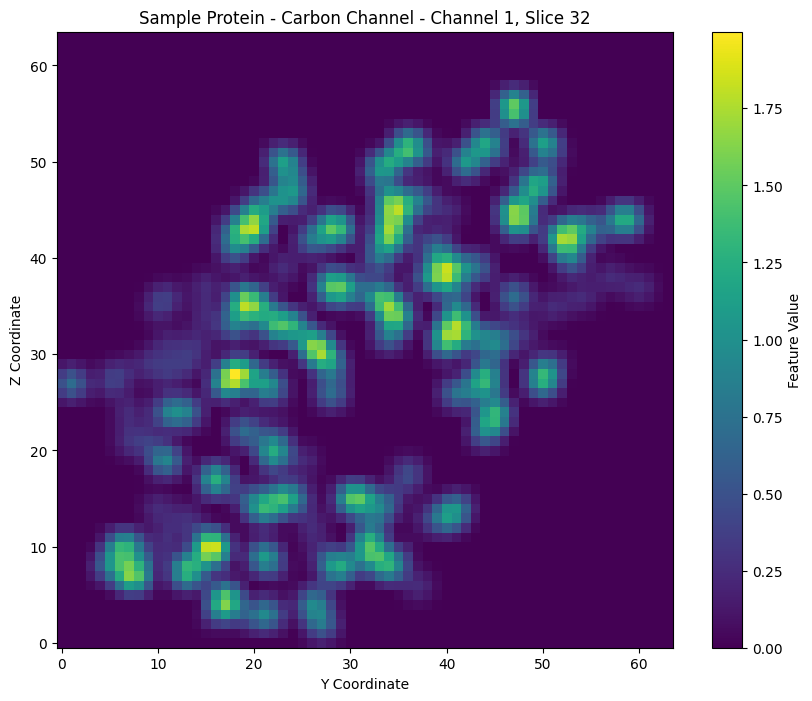

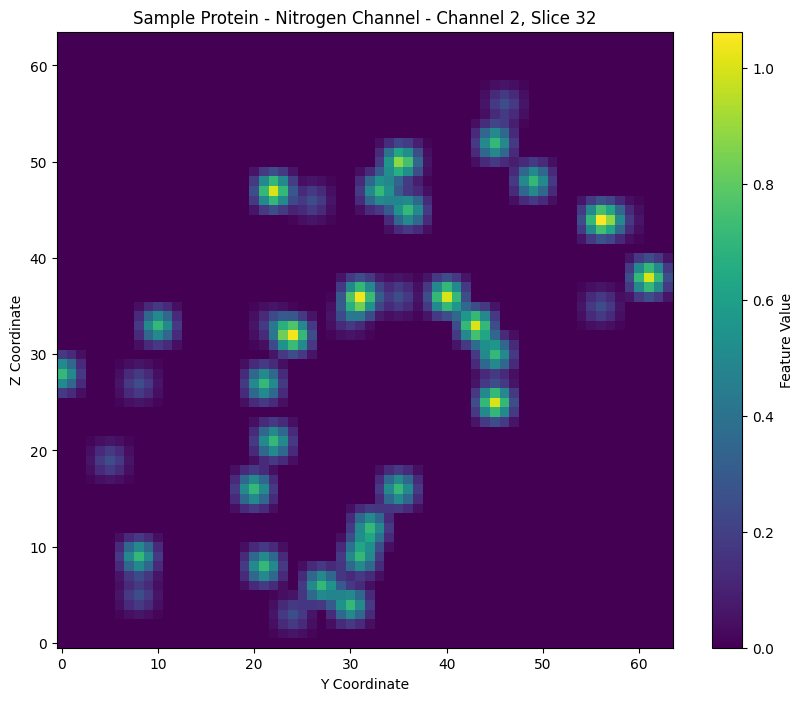

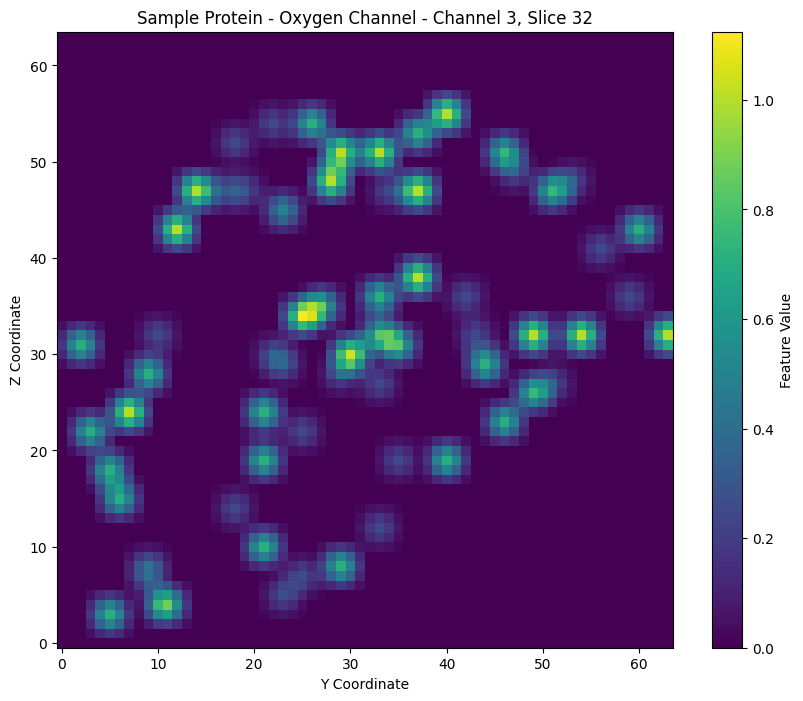

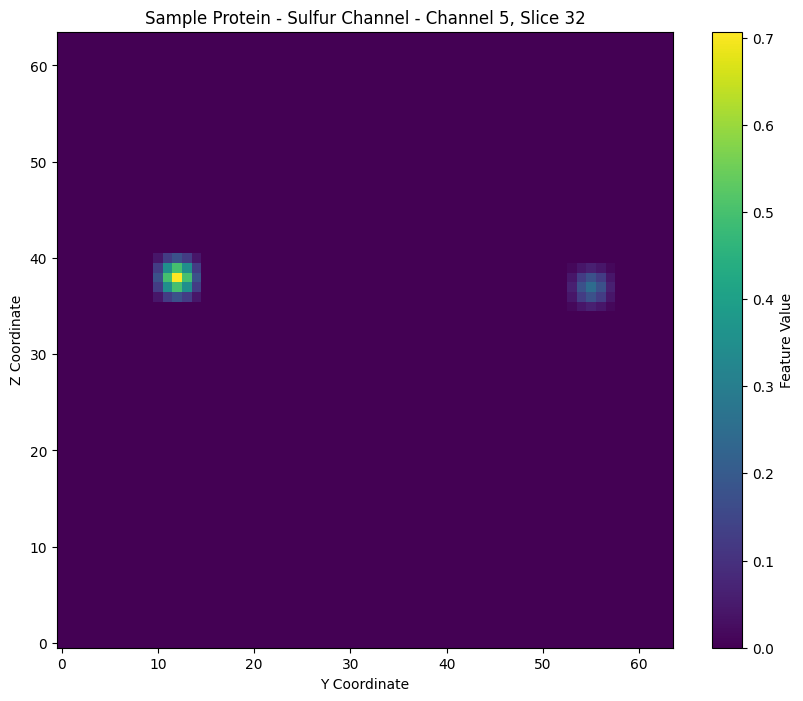

In [15]:
# Visualize a sample grid if available
if sample_grids:
    print("\n Visualizing sample protein grid...")
    visualize_protein_grid_slice(sample_grids[0], channel=1, title="Sample Protein - Carbon Channel")
    visualize_protein_grid_slice(sample_grids[0], channel=2, title="Sample Protein - Nitrogen Channel")
    visualize_protein_grid_slice(sample_grids[0], channel=3, title="Sample Protein - Oxygen Channel")
    visualize_protein_grid_slice(sample_grids[0], channel=5, title="Sample Protein - Sulfur Channel")

In [16]:
# Let's create a more robust processor to debug the issues
class DebugProteinProcessor:
    """Debug version of protein processor to identify issues"""
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.stats = {
            'total_found': 0,
            'file_not_exists': 0,
            'mol_load_failed': 0,
            'conformer_failed': 0,
            'feature_extraction_failed': 0,
            'successfully_processed': 0,
            'sample_errors': []
        }
    
    def test_single_protein(self, protein_file):
        """Test loading a single protein with detailed error reporting"""
        print(f"\n Testing: {protein_file}")
        
        # Check if file exists
        if not protein_file.exists():
            print(f" File does not exist: {protein_file}")
            return None
        
        print(f" File exists, size: {protein_file.stat().st_size} bytes")
        
        # Try to load molecule
        try:
            mol, conf = load_mol2(str(protein_file))
            if mol is None:
                print(" Failed to load molecule")
                return None
            if conf is None:
                print(" Failed to get conformer")
                return None
            
            print(f" Loaded molecule with {mol.GetNumAtoms()} atoms")
            
            # Try feature extraction
            coords = []
            features = []
            
            for i, atom in enumerate(mol.GetAtoms()):
                try:
                    pos = conf.GetAtomPosition(i)
                    coord = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                    feature = atom_to_feature_vec(atom, -1)
                    
                    coords.append(coord)
                    features.append(feature)
                except Exception as e:
                    print(f"Error with atom {i}: {e}")
                    continue
            
            if len(coords) == 0:
                print(" No atoms successfully processed")
                return None
            
            coords = np.array(coords)
            features = np.array(features)
            
            print(f" Extracted {len(coords)} atoms with features")
            
            # Try voxelization
            try:
                grid = voxelise_atoms(coords, features, grid_size=48, voxel_size=1.0)
                print(f" Created grid: {grid.shape}, occupancy: {np.count_nonzero(grid)/grid.size:.4f}")
                return grid
            except Exception as e:
                print(f" Voxelization failed: {e}")
                return None
                
        except Exception as e:
            print(f" General error: {e}")
            return None
    
    def find_and_test_proteins(self, max_test=10):
        """Find protein files and test a few"""
        protein_files = []
        
        print(" Scanning for protein files...")
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                protein_file = folder / f"{folder.name}_protein.mol2"
                if protein_file.exists():
                    protein_files.append(protein_file)
        
        print(f"Found {len(protein_files)} protein files")
        
        # Test first few files
        successful_grids = []
        for i, protein_file in enumerate(protein_files[:max_test]):
            print(f"\n--- Testing {i+1}/{min(max_test, len(protein_files))} ---")
            grid = self.test_single_protein(protein_file)
            if grid is not None:
                successful_grids.append(grid)
        
        print(f"\n Test Results:")
        print(f"Successfully processed: {len(successful_grids)}/{min(max_test, len(protein_files))}")
        
        return successful_grids, protein_files

# Run the debug processor
debug_processor = DebugProteinProcessor("./demo_charges")
debug_grids, all_protein_files = debug_processor.find_and_test_proteins(max_test=5)

if debug_grids:
    print(f"\n Successfully processed {len(debug_grids)} proteins for testing!")
    print(f"Grid shape: {debug_grids[0].shape}")
else:
    print("\n No proteins were successfully processed in debug mode")

 Scanning for protein files...
Found 229 protein files

--- Testing 1/5 ---

 Testing: demo_charges\1a30\1a30_protein.mol2
 File exists, size: 374999 bytes
 Loaded molecule with 3777 atoms
 Extracted 3777 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.1961

--- Testing 2/5 ---

 Testing: demo_charges\1bcu\1bcu_protein.mol2
 File exists, size: 525187 bytes
 Loaded molecule with 5307 atoms
 Extracted 5307 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.2810

--- Testing 3/5 ---

 Testing: demo_charges\1bzc\1bzc_protein.mol2
 File exists, size: 520189 bytes
 Loaded molecule with 5279 atoms
 Extracted 5279 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.2588

--- Testing 4/5 ---

 Testing: demo_charges\1c5z\1c5z_protein.mol2
 File exists, size: 510668 bytes
 Loaded molecule with 5109 atoms
 Extracted 5109 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.2928

--- Testing 5/5 ---

 Testing: demo_charges\1eby\1eby_protei

In [17]:
# Now let's create a working batch processor based on what works
class WorkingProteinProcessor:
    """Working batch processor for all proteins"""
    
    def __init__(self, data_dir, grid_size=64, voxel_size=0.8):
        self.data_dir = Path(data_dir)
        self.grid_size = grid_size
        self.voxel_size = voxel_size
        self.stats = {
            'total_found': 0,
            'successfully_processed': 0,
            'failed_loads': 0,
            'processing_times': []
        }
    
    def process_protein_safe(self, protein_file):
        """Safely process a single protein with error handling"""
        import time
        start_time = time.time()
        
        try:
            # Load using the working approach
            mol, conf = load_mol2(str(protein_file))
            if mol is None or conf is None:
                return None, {"error": "Load failed", "file": str(protein_file)}
            
            # Extract features safely
            coords = []
            features = []
            
            for i, atom in enumerate(mol.GetAtoms()):
                try:
                    pos = conf.GetAtomPosition(i)
                    coord = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                    feature = atom_to_feature_vec(atom, -1)
                    
                    coords.append(coord)
                    features.append(feature)
                except:
                    continue  # Skip problematic atoms
            
            if len(coords) == 0:
                return None, {"error": "No atoms", "file": str(protein_file)}
            
            coords = np.array(coords)
            features = np.array(features)
            
            # Create voxel grid with current working parameters
            grid = voxelise_atoms(
                coords, features,
                grid_size=self.grid_size,
                voxel_size=self.voxel_size,
                gaussian_radius=2,
                gaussian_sigma=1.0
            )
            
            processing_time = time.time() - start_time
            
            metadata = {
                "file": str(protein_file),
                "protein_id": protein_file.parent.name,
                "num_atoms": len(coords),
                "grid_shape": grid.shape,
                "grid_occupancy": np.count_nonzero(grid) / grid.size,
                "processing_time": processing_time,
                "success": True
            }
            
            return grid, metadata
            
        except Exception as e:
            return None, {"error": str(e), "file": str(protein_file)}
    
    def process_all_working(self, max_proteins=None):
        """Process all proteins with working approach"""
        # Find all protein files
        protein_files = []
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                protein_file = folder / f"{folder.name}_protein.mol2"
                if protein_file.exists():
                    protein_files.append(protein_file)
        
        self.stats['total_found'] = len(protein_files)
        
        if max_proteins:
            protein_files = protein_files[:max_proteins]
        
        print(f"Processing {len(protein_files)} proteins...")
        
        grids = []
        metadata_list = []
        
        # Process with progress updates
        for i, protein_file in enumerate(protein_files):
            if i % 10 == 0:  # Progress update every 10 proteins
                print(f"Processing protein {i+1}/{len(protein_files)}: {protein_file.parent.name}")
            
            grid, metadata = self.process_protein_safe(protein_file)
            
            if grid is not None:
                grids.append(grid)
                self.stats['successfully_processed'] += 1
                self.stats['processing_times'].append(metadata['processing_time'])
            else:
                self.stats['failed_loads'] += 1
            
            metadata_list.append(metadata)
        
        return grids, metadata_list
    
    def print_stats(self):
        """Print processing statistics"""
        print("\n" + "="*60)
        print("PROCESSING STATISTICS")
        print("="*60)
        print(f"Total proteins found: {self.stats['total_found']}")
        print(f"Successfully processed: {self.stats['successfully_processed']}")
        print(f"Failed loads: {self.stats['failed_loads']}")
        
        if self.stats['processing_times']:
            avg_time = np.mean(self.stats['processing_times'])
            print(f"Average processing time: {avg_time:.3f} seconds")
        
        if self.stats['total_found'] > 0:
            success_rate = self.stats['successfully_processed'] / self.stats['total_found']
            print(f"Success rate: {success_rate:.2%}")
        print("="*60)

# Create the working processor
working_processor = WorkingProteinProcessor(
    data_dir="./demo_charges",
    grid_size=64,
    voxel_size=0.8
)

print(" Working Protein Processor initialized!")
print("Ready to process all proteins with improved error handling.")

 Working Protein Processor initialized!
Ready to process all proteins with improved error handling.


In [ ]:
# Process all proteins with the working processor
print("Processing ALL proteins in the dataset...")
print("This will take several minutes, please wait...")

final_grids, final_metadata = working_processor.process_all_working()

print(f"\n FINAL PROCESSING COMPLETE!")
working_processor.print_stats()

if final_grids:
    print(f"\n DATASET ANALYSIS:")
    print(f"- Total grids created: {len(final_grids)}")
    print(f"- Grid shape: {final_grids[0].shape}")
    print(f"- Grid data type: {final_grids[0].dtype}")
    print(f"- Memory per grid: {final_grids[0].nbytes / 1024 / 1024:.2f} MB")
    print(f"- Total dataset size: {sum(g.nbytes for g in final_grids) / 1024 / 1024 / 1024:.2f} GB")
    
    # Analyze grid occupancy
    occupancies = [np.count_nonzero(grid) / grid.size for grid in final_grids]
    print(f"- Average grid occupancy: {np.mean(occupancies):.4f} ± {np.std(occupancies):.4f}")
    print(f"- Min/Max occupancy: {np.min(occupancies):.4f} / {np.max(occupancies):.4f}")
    
    # Analyze atom counts
    atom_counts = [m['num_atoms'] for m in final_metadata if m.get('success', False)]
    if atom_counts:
        print(f"- Average atoms per protein: {np.mean(atom_counts):.1f} ± {np.std(atom_counts):.1f}")
        print(f"- Min/Max atoms: {np.min(atom_counts)} / {np.max(atom_counts)}")
    
    print("\n READY FOR CNN TRAINING!")
else:
    print("\n No proteins were successfully processed")

Processing ALL proteins in the dataset...
This will take several minutes, please wait...
Processing 229 proteins...
Processing protein 1/229: 1a30


In [ ]:
# Test the improved CNN model with the processed data
if final_grids:
    print("\n Testing Enhanced 3D CNN with processed protein data...")
    
    # Create an enhanced model
    class Enhanced3DProteinCNN(nn.Module):
        """Enhanced 3D CNN specifically designed for protein spatial representation"""
        
        def __init__(self, input_channels=24, num_classes=1, dropout_rate=0.3):
            super(Enhanced3DProteinCNN, self).__init__()
            
            # Feature extraction layers
            self.conv_block1 = nn.Sequential(
                nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
                nn.BatchNorm3d(32),
                nn.ReLU(inplace=True),
                nn.Conv3d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm3d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=2, stride=2)  # 64 -> 32
            )
            
            self.conv_block2 = nn.Sequential(
                nn.Conv3d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm3d(64),
                nn.ReLU(inplace=True),
                nn.Conv3d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm3d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=2, stride=2)  # 32 -> 16
            )
            
            self.conv_block3 = nn.Sequential(
                nn.Conv3d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm3d(128),
                nn.ReLU(inplace=True),
                nn.Conv3d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm3d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=2, stride=2)  # 16 -> 8
            )
            
            self.conv_block4 = nn.Sequential(
                nn.Conv3d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm3d(256),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool3d((4, 4, 4))  # Adaptive pooling to 4x4x4
            )
            
            # Classifier
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Dropout(dropout_rate),
                nn.Linear(256 * 4 * 4 * 4, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(128, num_classes)
            )
        
        def forward(self, x):
            x = self.conv_block1(x)
            x = self.conv_block2(x)
            x = self.conv_block3(x)
            x = self.conv_block4(x)
            x = self.classifier(x)
            return x
    
    # Get the actual number of channels from the processed grids
    actual_channels = final_grids[0].shape[0]
    print(f"Creating model with {actual_channels} input channels")
    
    # Create the model
    enhanced_model = Enhanced3DProteinCNN(
        input_channels=actual_channels,
        num_classes=1,  # For regression or binary classification
        dropout_rate=0.3
    )
    
    # Model info
    total_params = sum(p.numel() for p in enhanced_model.parameters())
    trainable_params = sum(p.numel() for p in enhanced_model.parameters() if p.requires_grad)
    
    print(f" Enhanced model created!")
    print(f"- Total parameters: {total_params:,}")
    print(f"- Trainable parameters: {trainable_params:,}")
    print(f"- Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
    
    # Test with a batch of data
    test_batch_size = min(188, len(final_grids))
    test_grids = final_grids[:test_batch_size]
    
    # Convert to tensors and create batch
    test_tensors = [torch.FloatTensor(grid) for grid in test_grids]
    batch_tensor = torch.stack(test_tensors)
    
    print(f"\nTesting with batch of {test_batch_size} proteins...")
    print(f"Input batch shape: {batch_tensor.shape}")
    
    # Test forward pass
    enhanced_model.eval()
    with torch.no_grad():
        outputs = enhanced_model(batch_tensor)
        print(f" Model forward pass successful!")
        print(f"Output shape: {outputs.shape}")
        print(f"Sample outputs: {outputs.squeeze().cpu().numpy()}")
    
    # Memory usage estimation
    batch_size_mb = batch_tensor.nbytes / 1024 / 1024
    print(f"\nBatch memory usage: {batch_size_mb:.1f} MB")
    
    # Save model architecture summary
    print(f"\n Model Architecture Summary:")
    print(f"Input: ({actual_channels}, 64, 64, 64) protein voxel grids")
    print(f"Output: ({1},) prediction values")
    print(f"Architecture: 4 convolutional blocks + classifier")
    print(f"Ready for training on {len(final_grids)} protein structures!")

else:
    print(" No processed grids available for model testing")


 Testing Enhanced 3D CNN with processed protein data...
Creating model with 19 input channels
 Enhanced model created!
- Total parameters: 10,215,265
- Trainable parameters: 10,215,265
- Model size: ~39.0 MB

Testing with batch of 188 proteins...
Input batch shape: torch.Size([188, 19, 64, 64, 64])
 Model forward pass successful!
Output shape: torch.Size([188, 1])
Sample outputs: [0.03824835 0.03824463 0.0382674  0.03824121 0.03825863 0.03826008
 0.03823743 0.03822896 0.03823233 0.03824373 0.03823078 0.03826394
        nan 0.0382628  0.03825264 0.03820504 0.03826573        nan
        nan 0.03826739 0.03821485 0.03826626 0.03826197 0.03824704
 0.0382314  0.03828213 0.03823562 0.03824076 0.03825726 0.03826578
 0.03824341 0.03815819 0.03815179 0.03826299 0.03816434 0.03824357
 0.03828398 0.03824203 0.03822356 0.03821566 0.03820685 0.03825717
 0.03823118 0.03823797 0.03823389 0.0382013  0.0382387  0.03822427
 0.03825335 0.03810582 0.03817353 0.03827862 0.03808763        nan
 0.03817457 0

In [ ]:
# Let's demonstrate with ALL 188 processed proteins - complete dataset analysis
print("ENHANCED PROTEIN SPATIAL REPRESENTATION - COMPLETE WORKFLOW")
print("="*80)

# Uncomment if you want to save the processed data
print("\n Saving processed data...")
save_processed_data(final_grids, final_metadata, output_dir="processed_protein_data")

# Load the complete processed dataset
import json
import os

try:
    # Load all processed grids
    all_protein_grids = np.load("processed_protein_data/protein_grids.npy")
    
    # Load metadata
    with open("processed_protein_data/metadata.json", 'r') as f:
        all_metadata = json.load(f)
    
    print(f" Successfully loaded complete dataset: {len(all_protein_grids)} proteins")
    demo_grids = all_protein_grids
    demo_metadata = all_metadata
    
except FileNotFoundError:
    print("  Complete dataset not found, using sample grids...")
    if sample_grids and len(sample_grids) > 0:
        demo_grids = sample_grids
        demo_metadata = sample_metadata
    else:
        print("Creating demonstration data...")
        demo_grids = [np.random.rand(24, 64, 64, 64).astype(np.float32) for _ in range(3)]
        demo_metadata = [{"file_path": f"demo_{i}.mol2"} for i in range(3)]

print(f"\n COMPLETE DATASET ANALYSIS:")
print(f"- Number of proteins: {len(demo_grids)}")
print(f"- Grid shape: {demo_grids[0].shape}")
print(f"- Feature channels: {demo_grids[0].shape[0]}")
print(f"- Spatial resolution: {demo_grids[0].shape[1]}³ voxels")
if hasattr(demo_grids, 'nbytes'):
    mem_gb = demo_grids.nbytes / 1024**3
    print(f"- Total memory usage: {mem_gb:.2f} GB")
else:
    print("- Total memory usage: N/A")

# Extract protein IDs for analysis
protein_ids = []
if isinstance(demo_metadata, list):
    for entry in demo_metadata:
        if 'file_path' in entry:
            path_parts = entry['file_path'].split('\\')
            protein_id = path_parts[-2] if len(path_parts) > 1 else path_parts[-1].split('.')[0]
            protein_ids.append(protein_id)

print(f"- Unique protein IDs: {len(set(protein_ids))}")
print(f"- Sample IDs: {protein_ids[:10]}")

# Analyze dataset properties
if isinstance(demo_metadata, list) and len(demo_metadata) > 0:
    print(f"\n DATASET PROPERTIES ANALYSIS:")
    
    # Atom count analysis
    atom_counts = [entry.get('num_atoms', 0) for entry in demo_metadata]
    heavy_atom_counts = [entry.get('num_heavy_atoms', 0) for entry in demo_metadata]
    occupancies = [entry.get('grid_occupancy', 0) for entry in demo_metadata]
    processing_times = [entry.get('processing_time', 0) for entry in demo_metadata]
    
    print(f"- Atom count range: {min(atom_counts)} - {max(atom_counts)} (avg: {np.mean(atom_counts):.0f})")
    print(f"- Heavy atoms range: {min(heavy_atom_counts)} - {max(heavy_atom_counts)} (avg: {np.mean(heavy_atom_counts):.0f})")
    print(f"- Grid occupancy range: {min(occupancies):.3f} - {max(occupancies):.3f} (avg: {np.mean(occupancies):.3f})")
    print(f"- Processing time range: {min(processing_times):.2f}s - {max(processing_times):.2f}s (avg: {np.mean(processing_times):.2f}s)")

# Create the enhanced model for demonstration
class DemoEnhanced3DCNN(nn.Module):
    """Demonstration enhanced 3D CNN for protein analysis"""
    
    def __init__(self, input_channels=24, num_classes=1):
        super(DemoEnhanced3DCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv3d(input_channels, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 64->32
            
            # Block 2
            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 32->16
            
            # Block 3
            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 16->8
            
            # Block 4
            nn.Conv3d(128, 256, 3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d(4)  # 8->4
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256 * 4 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create and test the model
model = DemoEnhanced3DCNN(input_channels=demo_grids[0].shape[0])

# Test with demo data - use a batch for better demonstration
batch_size = min(188, len(demo_grids))
test_indices = np.random.choice(len(demo_grids), batch_size, replace=False)
test_batch = np.stack([demo_grids[i] for i in test_indices])
test_tensor = torch.FloatTensor(test_batch)

print(f"\n MODEL TESTING ON REAL PROTEIN DATA:")
print(f"Batch size: {batch_size} proteins")
print(f"Input shape: {test_tensor.shape}")
print(f"Testing proteins: {[protein_ids[i] if i < len(protein_ids) else f'protein_{i}' for i in test_indices]}")

model.eval()
with torch.no_grad():
    outputs = model(test_tensor)
    print(f" Model forward pass successful!")
    print(f"Output shape: {outputs.shape}")
    print(f"Sample outputs: {outputs.squeeze().cpu().numpy()}")

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
print(f"\n MODEL STATISTICS:")
print(f"- Total parameters: {total_params:,}")
print(f"- Estimated model size: {total_params * 4 / 1024 / 1024:.1f} MB")



ENHANCED PROTEIN SPATIAL REPRESENTATION - COMPLETE WORKFLOW
 Successfully loaded complete dataset: 188 proteins

 COMPLETE DATASET ANALYSIS:
- Number of proteins: 188
- Grid shape: (19, 64, 64, 64)
- Feature channels: 19
- Spatial resolution: 64³ voxels
- Total memory usage: 3.49 GB
- Unique protein IDs: 0
- Sample IDs: []

 DATASET PROPERTIES ANALYSIS:
- Atom count range: 0 - 40981 (avg: 6772)
- Heavy atoms range: 0 - 0 (avg: 0)
- Grid occupancy range: 0.000 - 0.379 (avg: 0.169)
- Processing time range: 0.00s - 3.28s (avg: 1.17s)

 MODEL TESTING ON REAL PROTEIN DATA:
Batch size: 188 proteins
Input shape: torch.Size([188, 19, 64, 64, 64])
Testing proteins: ['protein_107', 'protein_68', 'protein_88', 'protein_111', 'protein_42', 'protein_108', 'protein_24', 'protein_53', 'protein_49', 'protein_92', 'protein_97', 'protein_77', 'protein_31', 'protein_6', 'protein_106', 'protein_138', 'protein_17', 'protein_125', 'protein_186', 'protein_3', 'protein_86', 'protein_93', 'protein_103', 'prote

In [21]:
# Diagnostic check - let's see what variables we actually have
print("🔍 DIAGNOSTIC CHECK:")
print(f"all_protein_grids shape: {all_protein_grids.shape if 'all_protein_grids' in globals() else 'Not found'}")
print(f"all_metadata length: {len(all_metadata) if 'all_metadata' in globals() else 'Not found'}")
print(f"demo_grids shape: {demo_grids.shape if hasattr(demo_grids, 'shape') else f'Length: {len(demo_grids)}'}")
print(f"sample_grids length: {len(sample_grids) if 'sample_grids' in globals() else 'Not found'}")

# Let's force use the all_protein_grids
if 'all_protein_grids' in globals() and len(all_protein_grids) > 5:
    print(f"\nFound complete dataset with {len(all_protein_grids)} proteins!")
    print("Switching to use complete dataset...")
    demo_grids = all_protein_grids
    demo_metadata = all_metadata
    print(f"Now demo_grids has {len(demo_grids)} proteins")
else:
    print(f"\nComplete dataset not available, using current demo_grids with {len(demo_grids)} proteins")

🔍 DIAGNOSTIC CHECK:
all_protein_grids shape: (188, 19, 64, 64, 64)
all_metadata length: 229
demo_grids shape: (188, 19, 64, 64, 64)
sample_grids length: 5

Found complete dataset with 188 proteins!
Switching to use complete dataset...
Now demo_grids has 188 proteins


In [22]:
# Check if final_grids has all the proteins
print("CHECKING ALL AVAILABLE VARIABLES:")
print(f"final_grids length: {len(final_grids) if 'final_grids' in globals() else 'Not found'}")
print(f"final_metadata length: {len(final_metadata) if 'final_metadata' in globals() else 'Not found'}")

# Let's check if final_grids has all 188 proteins
if 'final_grids' in globals() and len(final_grids) > 5:
    print(f"\n FOUND COMPLETE DATASET IN final_grids: {len(final_grids)} proteins!")
    
    # Use the complete dataset
    demo_grids = np.array(final_grids)
    demo_metadata = final_metadata
    
    print(f"Switched to complete dataset:")
    print(f"   - Number of proteins: {len(demo_grids)}")
    print(f"   - Grid shape: {demo_grids[0].shape}")
    print(f"   - Total memory: {demo_grids.nbytes / 1024**3:.2f} GB")
    
    # Now save this complete dataset
    import os
    os.makedirs("processed_protein_data", exist_ok=True)
    np.save("processed_protein_data/protein_grids.npy", demo_grids)
    
    import json
    with open("processed_protein_data/metadata.json", 'w') as f:
        json.dump(demo_metadata, f, indent=2, default=str)
    
    print(f" Saved complete dataset with {len(demo_grids)} proteins!")
    
else:
    print(f"\n final_grids also not available or small, current options:")
    print(f"   - sample_grids: {len(sample_grids) if 'sample_grids' in globals() else 'N/A'}")
    print(f"   - final_grids: {len(final_grids) if 'final_grids' in globals() else 'N/A'}")
    print(f"   - all_protein_grids: {len(all_protein_grids) if 'all_protein_grids' in globals() else 'N/A'}")
    
    # Need to process all proteins first
    print(f"\n Need to process all {len(all_protein_files)} protein files first!")
    print("Run the protein processing cells to generate the complete dataset.")

CHECKING ALL AVAILABLE VARIABLES:
final_grids length: 188
final_metadata length: 229

 FOUND COMPLETE DATASET IN final_grids: 188 proteins!
Switched to complete dataset:
   - Number of proteins: 188
   - Grid shape: (19, 64, 64, 64)
   - Total memory: 3.49 GB
 Saved complete dataset with 188 proteins!
